In [8]:
import requests
import pandas as pd

# Importing HPI data and Vaccine data
hpi_data = requests.get('https://api.healthyplacesindex.org/api/hpi?geography=tracts&year=2020&indicator=voting&format=json&key=f07f86d6-58b5-40e3-a17f-333b92ccc57d').json()
vaccine_data = requests.get('https://data.sandiegocounty.gov/resource/nrkb-eanb.json').json()

# hpi_data
# vaccine_data

# Converting data (python dictionary) to a pandas dataframe
# Resetting titles (variables) the dataframe versions
hpi_data = pd.DataFrame.from_dict(hpi_data)
vaccine_data = pd.DataFrame.from_dict(vaccine_data)


# hpi_data.head(1)
vaccine_data.head(1)
# df_hpi_data

,the_geom,objectid,census_tract,count_vaccinated,gis_hpi_quartile_sd,doses_through,update_date,shape_length,shape_area,globalid,vaccination_percentage_all,censuspop_all,notes,censuspop_16plus,vaccination_percentage,censuspop_5plus,vaccination_percentage_5plus,censuspop_12plus,vaccination_percentage_12plus
0,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",52148,27.09,2611,1,2022-07-25T08:00:00.000Z,2022-07-27T08:00:00.000Z,4542.22806061985,863204.6140417,{7180F893-7DCF-42C7-9C81-170B0BE32E62},71.33879781,3660,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
hpi_data.head(1)

,geoid,name,population,value,percentile,numerator,denominator
0,06013370000,3700,2850,0.848177,0.726187,1805.769339,2129


In [23]:
#Import from Google Drive - Master HPI Data. Recieved this file directly from the HPI agency. 
# Will use this file as an intermidiary- common key is needed from this file to join HPI data and Vaccine data

import pandas as pd

url='https://drive.google.com/file/d/1-O5aXOkgAaQUxMjZ5EXu9y6kHxmjsyp2/view?usp=share_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
master_hpi = pd.read_csv(path)

#Cleaning/Filtering mster HPI data. Preparing to join. 
san_diego_hpi = master_hpi[master_hpi['county']=='San Diego']

san_diego_hpi['NAME'] = [x.split(',')[-0] for x in san_diego_hpi['NAME']]

san_diego_hpi['NAME'] = [x.split('Tract ')[-1] for x in san_diego_hpi['NAME']]

san_diego_hpi.head(1)

C:\Users\krist\AppData\Local\Temp\ipykernel_106460\1791725292.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  san_diego_hpi['NAME'] = [x.split(',')[-0] for x in san_diego_hpi['NAME']]
C:\Users\krist\AppData\Local\Temp\ipykernel_106460\1791725292.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  san_diego_hpi['NAME'] = [x.split('Tract ')[-1] for x in san_diego_hpi['NAME']]


,GEO_ID,NAME,county,pop,pctgqtract,UrbanType,LEB,LEB_pctile,hpi,hpi_pctile,...,latino_pct,white_pct,black_pct,asian_pct,multiple_pct,NativeAm_pct,PacificIsl_pct,other_pct,version,notes
5658,6073000100,1,San Diego,3093,0.0,urban_area,88.0,0.990436,1.048395,0.975995,...,0.158,0.772,0.0,0.036,0.033,0.0,0.0,0.0,2/10/2022,NaN


In [26]:
# Joining datasets

vaccine_data['NAME'] = pd.Series(san_diego_hpi['NAME'])

vaccine_data

,the_geom,objectid,census_tract,count_vaccinated,gis_hpi_quartile_sd,doses_through,update_date,shape_length,shape_area,globalid,vaccination_percentage_all,censuspop_all,notes,censuspop_16plus,vaccination_percentage,censuspop_5plus,vaccination_percentage_5plus,censuspop_12plus,vaccination_percentage_12plus,NAME
0,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",52148,27.09,2611,1,2022-07-25T08:00:00.000Z,2022-07-27T08:00:00.000Z,4542.22806061985,863204.6140417,{7180F893-7DCF-42C7-9C81-170B0BE32E62},71.33879781,3660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",51876,120.02,2838,1,2022-07-25T08:00:00.000Z,2022-07-27T08:00:00.000Z,4580.147408856571,793645.91325221,{8A80FD90-06C3-476C-845B-A231A626E0FE},74.56647399,3806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",52277,138.02,2338,1,2022-07-25T08:00:00.000Z,2022-07-27T08:00:00.000Z,4016.758175986109,1002367.668396985,{B800AA52-5027-4F7D-9AC1-C21F887254DF},72.83489097,3210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",52292,200.18,5664,1,2022-07-25T08:00:00.000Z,2022-07-27T08:00:00.000Z,10178.606701530427,4163633.717257715,{043A36B9-9363-47AA-8E11-B8CA53283521},76.02684564,7450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",52185,113,NaN,NaN,2022-07-25T08:00:00.000Z,2022-07-27T08:00:00.000Z,16511.596929115294,13809956.0809563,{12860415-1CC3-4388-AF85-B0AAD8F2D915},NaN,5124,Censored,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",53092,31.14,2635,2,2022-08-08T08:00:00.000Z,2022-08-10T08:00:00.000Z,5456.112504639252,1603523.55990848,{D92822FA-61C8-4607-8C00-8DCBB0AE5ABB},89.59537572,2941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",52437,192.06,3786,1,2022-08-01T08:00:00.000Z,2022-08-03T08:00:00.000Z,6434.45383417595,2071050.530711345,{F343E335-F86A-4316-A231-4CD63556C2FA},74.22074103,5101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",52638,46,1589,2,2022-08-01T08:00:00.000Z,2022-08-03T08:00:00.000Z,3121.2609472941317,572411.37527332,{DB3301E8-6BA0-43C9-AA7A-E85D7DB9CB59},64.59349593,2460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",52480,83.13,2302,4,2022-08-01T08:00:00.000Z,2022-08-03T08:00:00.000Z,11248.56892279628,3462094.52569419,{EC0DAD02-ED0D-4ADE-B1D8-C5B4667CCCE8},97.83255419,2353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


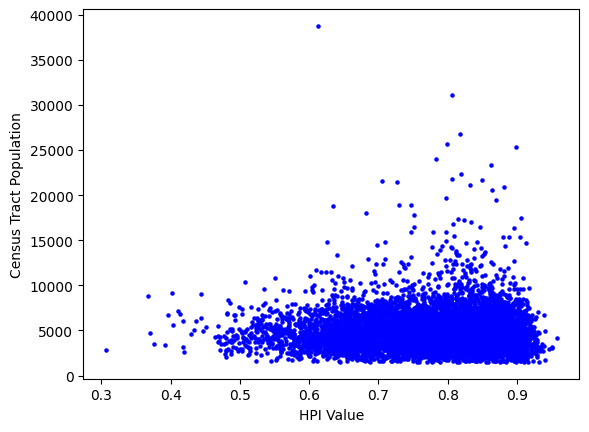

In [41]:
# Producing a Visual

import matplotlib.pyplot as plt

val_by_population = plt.scatter(hpi_data['value'],hpi_data['population'], c='blue', s=5)
val_by_population = plt.xlabel('HPI Value')
val_by_population = plt.ylabel('Census Tract Population')

plt.show(val_by_population)


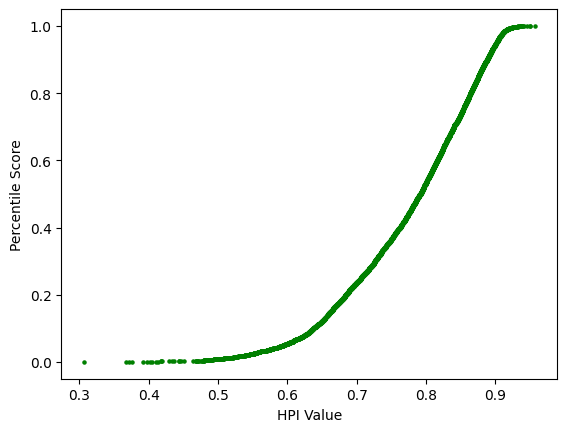

In [40]:
# Visual

val_by_percentile = plt.scatter(hpi_data['value'],hpi_data['percentile'], c='green', s=5)
val_by_percentile = plt.xlabel('HPI Value')
val_by_percentile = plt.ylabel('Percentile Score')

plt.show(val_by_percentile)